## Pull data from pixelstarships api, upload to an excel file

In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-

# ----- Packages ------------------------------------------------------
import csv
import datetime
import os
import urllib.parse
import urllib.request
import xml.etree.ElementTree


PSS_CHARS_FILE = 'pss-chars.txt'
PSS_CHARS_RAW_FILE = 'pss-chars-raw.txt'
PSS_LINKS_FILE = 'links.csv'
MAXIMUM_CHARACTERS = 1900

In [2]:
def save_raw_text(raw_text, filename):
    try:
        with open(filename, 'w') as f:
            f.write(raw_text)
    except:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(raw_text)

def get_data_from_url(url):
    data = urllib.request.urlopen(url).read()
    return data.decode('utf-8')

def load_data_from_url(filename, url, refresh='auto'):
    if os.path.isfile(filename) and refresh != 'true':
        if refresh == 'auto':
            if is_old_file(filename, max_seconds=3600):
                raw_text = get_data_from_url(url)
                save_raw_text(raw_text, filename)
                return raw_text
        with open(filename, 'r') as f:
            raw_text = f.read()
    else:
        raw_text = get_data_from_url(url)
        save_raw_text(raw_text, filename)
    return raw_text

def xmltree_to_dict2(raw_text, key=None):
    root = xml.etree.ElementTree.fromstring(raw_text)
    for c in root:
        d = {}
        for cc in c:
            if key is None:
                d = cc.attrib
            else:
                d[cc.attrib[key]] = cc.attrib
    return d

def xmltree_to_dict3(raw_text, key):
    root = xml.etree.ElementTree.fromstring(raw_text)
    for c in root:
        for cc in c:
            d = {}
            for ccc in cc:
                d[ccc.attrib[key]] = ccc.attrib
    return d


def create_reverse_lookup(d, new_key, new_value):
    """Creates a dictionary of the form:
    {'new_key': 'new_value'}"""
    rlookup = {}
    for key in d.keys():
        item = d[key]
        rlookup[item[new_key]] = item[new_value]
    return rlookup


# ----- Get Production Server -----
def get_production_server():
    url = 'https://api.pixelstarships.com/SettingService/GetLatestVersion3?languageKey=en&deviceType=DeviceTypeAndroid'
    raw_text = get_data_from_url(url)
    d = xmltree_to_dict2(raw_text, key=None)
    return d['ProductionServer']

In [3]:
base_url = 'http://{}/'.format(get_production_server())

def request_new_char_sheet():
    # Download Character Sheet from PSS Servers
    url = base_url + 'CharacterService/ListAllCharacterDesigns?languageKey=en'
    data = urllib.request.urlopen(url).read()
    return data.decode()


def get_char_sheet(refresh='auto'):
    url = base_url + 'CharacterService/ListAllCharacterDesigns?languageKey=en'
    raw_text = load_data_from_url(PSS_CHARS_RAW_FILE, url, refresh=refresh)
    ctbl = xmltree_to_dict3(raw_text, 'CharacterDesignId')
    tbl_i2n = create_reverse_lookup(ctbl, 'CharacterDesignId', 'CharacterDesignName')
    tbl_n2i = create_reverse_lookup(ctbl, 'CharacterDesignName', 'CharacterDesignId')
    rarity = create_reverse_lookup(ctbl, 'CharacterDesignName', 'Rarity')
    return ctbl, tbl_i2n, tbl_n2i, rarity

In [4]:
ctbl, tbl_i2n, tbl_n2i, rarity = get_char_sheet(refresh='true')
txt = ''
for k,v in tbl_i2n.items():
    txt += f'{k},{v}\n'
with open('characters.csv', 'w') as f:
    f.write(txt)

In [7]:
# start with excel file headers
txt = ('CharacterDesignId,CharacterDesignName,RaceType,FinalHp,FinalPilot,FinalAttack,FinalRepair,'
'FinalWeapon,FinalScience,FinalEngine,Rarity,SpecialAbilityType,SpecialAbilityFinalArgument,'
'ProfileSpriteId,WalkingSpeed,RunSpeed,TrainingCapacity,EquipmentMask,CollectionDesignId,Flags,CharacterDesignDescription\n')

# Add character stats
for k in ctbl.keys():
    item=ctbl[k]
    
    txt += f"{item['CharacterDesignId']},"
    txt += f"{item['CharacterDesignName']},"
    txt += f"{item['RaceType']},"
    txt += f"{item['FinalHp']},"
    txt += f"{item['FinalPilot']},"
    txt += f"{item['FinalAttack']},"
    txt += f"{item['FinalRepair']},"
    txt += f"{item['FinalWeapon']},"
    txt += f"{item['FinalScience']},"
    txt += f"{item['FinalEngine']},"
    txt += f"{item['Rarity']},"
    txt += f"{item['SpecialAbilityType']},"
    txt += f"{item['SpecialAbilityFinalArgument']},"
    txt += f"{item['ProfileSpriteId']},"
    txt += f"{item['WalkingSpeed']},"
    txt += f"{item['RunSpeed']},"
    txt += f"{item['TrainingCapacity']},"
    txt += f"{item['EquipmentMask']},"
    txt += f"{item['CollectionDesignId']},"
    txt += f"{item['Flags']},"
    
    desc = item['CharacterDesignDescription'].replace(",", "")
    txt += f'{desc}\n'
    
with open('characters_fulldata.csv', 'w', encoding='utf-8') as f:
    f.write(txt)

## Read data from that excel file into python for ML

In [122]:
import pandas as pd #for data handling
from pandas import ExcelFile # for file reading
import numpy as np # for data manipulation and plotting
from progressbar import ProgressBar # for output monitoring

In [123]:
# import data from excel file
df = pd.read_csv('characters_fulldata.csv')
print("Column headings:")
print(df.columns)

Column headings:
Index(['CharacterDesignId', 'CharacterDesignName', 'RaceType', 'FinalHp',
       'FinalPilot', 'FinalAttack', 'FinalRepair', 'FinalWeapon',
       'FinalScience', 'FinalEngine', 'Rarity', 'SpecialAbilityType',
       'SpecialAbilityFinalArgument', 'ProfileSpriteId', 'WalkingSpeed',
       'RunSpeed', 'TrainingCapacity', 'EquipmentMask', 'CollectionDesignId',
       'Flags', 'CharacterDesignDescription'],
      dtype='object')


In [124]:
# drop the columns that don't have real meaning for the model (ex. name, desc, icon, etc)
feats_df = df.drop(['CharacterDesignId', 'ProfileSpriteId', 'CharacterDesignDescription'], axis=1)

In [125]:
feats_df.head()

,CharacterDesignName,RaceType,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,Rarity,SpecialAbilityType,SpecialAbilityFinalArgument,WalkingSpeed,RunSpeed,TrainingCapacity,EquipmentMask,CollectionDesignId,Flags
0,Laura,Unknown,6,18,1.9,1.7,4.0,7,3.0,Special,DeductReload,460,1,2,200,62,0,9
1,Lisa,Unknown,6,18,1.9,1.7,7.0,12,4.0,Special,HealSelfHp,6,1,2,200,62,0,9
2,Michelle,Unknown,6,18,1.9,1.7,13.0,4,3.0,Special,HealSameRoomCharacters,5,1,2,200,62,0,9
3,Bobby,Unknown,6,18,1.9,1.7,3.0,3,14.0,Special,AddReload,40,1,2,200,62,0,9
4,Edward,Unknown,6,18,1.9,1.7,3.0,6,4.0,Special,DamageToRoom,4,1,2,200,62,0,9


## Add columns for useful features

#### Add columns to flag crew that are particularly good or particularly bad at their given ability

In [126]:
# Create flags for really good or really bad ability scores 
# (+/- 2 std dev from the mean score for that ability)

p = False # for debugging

# get a list of all of the abilities
abilities = feats_df['SpecialAbilityType'].unique()

# this df will hold the low and high values, for flagging later
ability_stats_df = pd.DataFrame(columns=['AbilityType', 'low', 'high'])

# for each ability, calculate the mean +/- 2*stdev limits
for a in abilities:
    if p: print("\ncalculating ability stats for " + a)
    
    tempdf = feats_df[feats_df.SpecialAbilityType == a]
    stats = tempdf['SpecialAbilityFinalArgument']
    
    m = np.mean(stats)
    s = np.std(stats)
    
    stats_entry = {'AbilityType': a, 'low': m-2*s, 'high': m+2*s}
    if p: print(stats_entry)
    
    ability_stats_df = ability_stats_df.append(stats_entry, ignore_index=True)
    
if p: ability_stats_df.head()

In [127]:
# for each crew (row), set 'AbilityExtreme' to 
### 1 if low (bad at skill); 2 if high (good at skill); 0 otherwise

feats_df['AbilityExtreme'] = 0
pbar = ProgressBar()  # progress bar for cleaning loop

print("Finding crew with very low or high ability scores...")
for ind in pbar(range(len(feats_df))):
    a = feats_df['SpecialAbilityType'].values[ind]
    score = feats_df['SpecialAbilityFinalArgument'].values[ind]
    
    if score < float(ability_stats_df[ability_stats_df.AbilityType==a].low):
        feats_df['AbilityExtreme'].values[ind] = 1;
    elif score > float(ability_stats_df[ability_stats_df.AbilityType==a].high):
        feats_df['AbilityExtreme'].values[ind] = 2;

feats_df[feats_df.AbilityExtreme==2].head(100)

Finding crew with very low or high ability scores...


100% |########################################################################|


,CharacterDesignName,RaceType,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,Rarity,SpecialAbilityType,SpecialAbilityFinalArgument,WalkingSpeed,RunSpeed,TrainingCapacity,EquipmentMask,CollectionDesignId,Flags,AbilityExtreme
116,Meowy Cat,Animal,7,7,3.3,2.0,10.0,10,10.0,Special,DamageToCurrentEnemy,17,1,2,100,12,3,3,2
151,Dr Dong,Asian,14,14,2.0,1.5,14.0,12,12.0,Special,HealSelfHp,14,1,2,100,6,0,3,2
223,Daft Kittus,Animal,9,7,3.1,2.0,9.0,9,9.0,Special,DamageToCurrentEnemy,17,1,2,100,24,3,3,2
269,Schrodinger,Animal,6,7,3.3,2.2,10.0,16,10.0,Unique,HealRoomHp,17,1,1,70,24,3,19,2
271,Angel,White,9,13,2.5,2.5,17.0,18,18.0,Hero,HealSameRoomCharacters,9,1,2,90,9,0,19,2
296,Alley Cat Zombie,Animal,9,7,3.3,1.1,10.0,10,10.0,Special,DamageToCurrentEnemy,17,1,2,100,12,3,3,2
341,Galactic Alchemist,White,12,12,2.0,2.0,17.0,29,14.0,Legendary,SetFire,1000,1,2,110,17,0,3,2


## HACKY HACK HACK

In [141]:
# drop a few columns that aren't ready yet
feats_df = feats_df.drop(['EquipmentMask', 'CollectionDesignId', 'Flags'], axis=1)

print("ready for modeling!")

ready for modeling!


## Grab the "true" labels from the excel file

In [142]:
# import data from excel file
df = pd.read_excel('gunnergrades.xlsx')
print("Column headings:")
print(df.columns)

crew_df = df

Column headings:
Index(['CrewName', 'Gunner'], dtype='object')


In [143]:
# for each character in the grades file, put the label in the "grade" column
feats_df['grade'] = 0 #default grade is 0, aka "F"
grades_list = ['F', 'D', 'C', 'B', 'A']

pbar = ProgressBar()
for ind in pbar(range(len(crew_df))):
    val = grades_list.index(crew_df['Gunner'].values[ind])
    feats_df.set_value(feats_df.CharacterDesignName == crew_df['CrewName'].values[ind], 'grade', val)

100% |########################################################################|


In [144]:
feats_df.head()

,CharacterDesignName,RaceType,FinalHp,FinalPilot,FinalAttack,FinalRepair,FinalWeapon,FinalScience,FinalEngine,Rarity,SpecialAbilityType,SpecialAbilityFinalArgument,WalkingSpeed,RunSpeed,TrainingCapacity,AbilityExtreme,grade
0,Laura,Unknown,6,18,1.9,1.7,4.0,7,3.0,Special,DeductReload,460,1,2,200,0,0
1,Lisa,Unknown,6,18,1.9,1.7,7.0,12,4.0,Special,HealSelfHp,6,1,2,200,0,0
2,Michelle,Unknown,6,18,1.9,1.7,13.0,4,3.0,Special,HealSameRoomCharacters,5,1,2,200,0,2
3,Bobby,Unknown,6,18,1.9,1.7,3.0,3,14.0,Special,AddReload,40,1,2,200,0,0
4,Edward,Unknown,6,18,1.9,1.7,3.0,6,4.0,Special,DamageToRoom,4,1,2,200,0,0


In [145]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
def analyze_feature(data, feat_name):
    print(data[feat_name].describe())
    plt.figure(figsize = (20,5))
    plt.subplot(1,3,2)
    sns.distplot(data[feat_name])
    plt.subplot(1,3,3)
    sns.boxplot(data[feat_name])

count    355.000000
mean       1.183099
std        1.305246
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: grade, dtype: float64


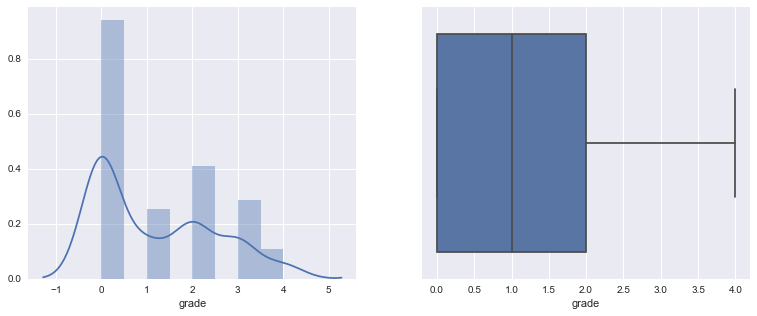

In [146]:
analyze_feature(feats_df, "grade")

## Let's try a model! Linear Regression first

In [157]:
# Pull out the first 80% of data points for training. Use the last 20% for test
features = feats_df.drop(['CharacterDesignName', 'SpecialAbilityFinalArgument', 'grade'], axis = 1)
labels = feats_df['grade']

n = len(labels)
split_n = int(np.floor(0.8*n))

train_features = features.values[0:split_n]
train_labels = labels.values[0:split_n]
test_features = features.values[split_n+1:]
test_labels = labels.values[split_n+1:]

In [158]:
from sklearn.linear_model import LinearRegression

# linear regression model
Regmodel = LinearRegression()
Regmodel.fit(train_features, train_labels)

print("The linear regression model achieves an R2 value of " + str(Regmodel.score(test_features, test_labels)))

y_pred = Regmodel.predict(test_features)
print("At worst, the predicted score was off by " + str(round(np.max(y_pred - test_labels),3)) + " grades.\n")

ValueError: could not convert string to float: 'None'